# Moment models fine-tune analysis | Mask test
> This notebook is the pre-analysis of moment models to select the cases used in the paper.

# RECORDATORIO 
1) Conseguir que compilen de nuevo
2) Enmascarar también en evaluación, no solo en training, majaretilla...

In [1]:
# Input parameters
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [2]:
#! pip install --no-deps ydata_profiling
#! pip install --no-deps dacite
#! pip install --no-deps multimethod
#! pip install --no-deps visions
#! pip install --no-deps wordcloud
#! pip install --no-deps imagehash
#! pip install --no-deps htmlmin

In [3]:
# Imports
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut
from dvats.imports import beep
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import ydata_profiling as ydp
import seaborn as sns

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(
Using the latest cached version of the module from /home/macu/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mse/5303f8acce26cdffcedb23101b42d1660bf34c3d8885adcd0bb262916312a51a (last modified on Mon Jan 27 15:41:53 2025) since it couldn't be found locally at evaluate-metric--mse, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from /home/macu/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mse/5303f8acce26cdffcedb23101b42d1660bf34c3d8885adcd0bb2629


Octave is ready <oct2py.core.Oct2Py object at 0x7fd6806a18a0>

















In [4]:
import torch
torch.cuda.set_device(0)
#torch.cuda.set_device(1)

In [5]:
from fastai.losses import MSELossFlat
from dvats.encoder import MAELossFlat, EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE
import dvats.config as cfg_
import gc
import os

### Setting up Weight & Biases information

In [6]:
# User and project
entity = os.environ.get("WANDB_ENTITY")
project = os.environ.get("WANDB_PROJECT")
folder = entity+'/'+project+'/'

# Dataset
dataset = 'gtrends_kohls'
dataset_version = 'v2'
enc_artifact_dataset = folder + dataset + ':' + dataset_version

# Models
model_family = 'zeroshot-moment'
task = 'embedding'
enc_artifact_small_name = folder + model_family + '-small-' + task + ':v0'
enc_artifact_base_name  =  folder + model_family + '-base-' + task + ':v0'
enc_artifact_large_name = folder + model_family + '-large-' + task + ':v0'

### Download dataset

In [7]:
print("Getting dataset artifact: ", enc_artifact_dataset)
df_artifact = wandb_api.artifact(enc_artifact_dataset, type = 'dataset')

Getting dataset artifact:  mi-santamaria/deepvats/gtrends_kohls:v2


In [8]:
print(df_artifact.name)
df = df_artifact.to_df()
display(df.head())
df.shape

gtrends_kohls:v2


wandb:   1 of 1 files downloaded.  


,volume
2004-01-01,0.010417
2004-01-08,0.010417
2004-01-15,0.010417
2004-01-22,0.000000
2004-01-29,0.000000


(440, 1)

### Encoder Input

In [9]:
enc_input, _ = SlidingWindow(window_len=17, stride=2, get_y=[])(df)
enc_input.shape

(212, 1, 17)

### Functions

In [10]:
def count_parameters(model):
    #return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

def greater_than(lst, val):
    vals = []
    for x in lst:
        try:
            x = int(x)
            if (x > val): 
                vals.append(x)
        except:
            continue
    return vals
    #return [ x for x in lst if isinstance(x, int) and x > val]

In [11]:
def plot_with_multiple_secondary_y(df, primary_vars, secondary_vars, figsize=(12, 6)):
    """
    Plots multiple variables with different scales on primary and secondary y-axes.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - primary_vars (list): Variables to plot on the primary y-axis.
    - secondary_vars (list): Variables to plot on the secondary y-axis.
    - figsize (tuple): Size of the figure.

    Returns:
    - None: Displays the plot.
    """
    ax = df[primary_vars + secondary_vars].plot(
        secondary_y=secondary_vars, figsize=figsize
    )
    ax.set_title("Variables with Primary and Secondary Axes")
    plt.show()

In [12]:
def plot_correlation(profile, figsize=(8, 6)):
    correlation_matrix = profile.corr()
    # Crear el heatmap con seaborn
    plt.figure(figsize = figsize)  # Ajusta el tamaño si es necesario
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix")
    plt.show()

### Common Fine-tune args

In [13]:
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

In [14]:
print(config['batch_size'])
print(config['r'])
print(config['analysis_mode'])

16
0.4
online


In [15]:
common_args = {
    "X": df,
    "stride": 1,
    "batch_size": config['batch_size'],
    "cpu": False,
    "to_numpy": False,
    "time_flag": True,
    "n_windows": None,
    "n_windows_percent": None,
    "shot": True,
    "eval_pre": True,
    "eval_post": True,
    "lr": config['r'], #use enc_run lr,
    "lr_scheduler_flag": False,
    "lr_scheduler_name": "cosine_with_restarts",
    "lr_scheduler_num_warmup_steps": None,
    "window_sizes": [12],
    "full_dataset": True,
    "window_sizes_offset": 0.05,
    "windows_min_distance": 0, #int(np.ceil(1.5*enc_input.shape[0]/100)),
    "print_to_path": True,
    "print_path": "./logs.txt",
    "print_mode": "w",
    "use_moment_masks": True,
    "mask_stateful": config['mask_stateful'],
    "mask_future": config['mask_future'],
    "mask_sync": config['mask_sync'],
    "analysis_mode": config['analysis_mode'],
    "use_wandb": config['use_wandb'],
    "norm_by_sample": config['norm_by_sample'],
    "norm_use_single_batch": config['norm_use_single_batch'],
    "show_plot": True,
    "metrics": [EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE],
    "metrics_args": [{'squared': False}, {'squared': True}, {}, {}],
    "metrics_names":["mse", "rmse", "mae", "smape"],
    "metrics_dict": None,
    "criterion": torch.nn.MSELoss()
}

In [16]:
common_args["windows_min_distance"]

0

### Cases execution function

In [17]:
from momentfm.utils.masking import Masking 

In [24]:
def cases_loop(
    model, 
    n_epochs_list, 
    dataset_percents, 
    maskared_percents, 
    n_sizes_list, 
    summarized = True, 
    do_beep = True, 
    verbose = 1,
    save = True,
    file_errors = "",
    file_results = ""
):
    mssg = ut.Mssg(verbose = verbose, level = -1)
    result_columns = [
        'model_size','n_epochs','dataset_percent','maskared_percent','n_windows', 
        'time',
        'first_train_loss','first_mse','first_rmse','first_mae','first_smape', 
        'last_train_loss','last_mse','last_rmse','last_mae','last_smape'
    ]
    result_columns = result_columns if summarized else result_columns + ['losses','eval_results_pre','eval_results_post']
    results = pd.DataFrame(columns = result_columns)
    
    errors = pd.DataFrame(
        columns = [
            'model_size',
            'n_epochs',
            'dataset_percent',
            'maskared_percent',
            'n_windows',
            'windows',
            'error'
        ]
    )
    model_backup = deepcopy(model)
    i = 0
    for n_epochs in n_epochs_list:
        for dataset_percent in dataset_percents:
            print(dataset_percent)
            for maskared_percent in maskared_percents:
                model.mask_generator = Masking(mask_ratio = maskared_percent)
                for sizes in n_sizes_list:
                    print(f"--> epoch {n_epochs}, dataset_percent {dataset_percent}, mask {maskared_percent}")
                    print(f" sizes {sizes}")
                    print(f"Cuda memmory allocated: {torch.cuda.memory_allocated()}")
                    model_case = deepcopy(model_backup)
                    case = {
                            'model_size': "small",
                            'n_epochs': n_epochs,
                            'dataset_percent': dataset_percent,
                            'maskared_percent': maskared_percent,
                            'n_windows': sizes,
                            'windows': None
                           }
                    result_dict = deepcopy(case)
                    error_dict = deepcopy(case)
                    error = False
                    print(1-dataset_percent)
                    result = fine_tune(
                        enc_learn           = model_case,
                        window_mask_percent = maskared_percent,
                        training_percent    = dataset_percent,
                        validation_percent  = 1-dataset_percent,
                        num_epochs          = n_epochs,
                        n_window_sizes      = sizes,
                        verbose             = verbose,
                        register_errors     = True,
                        save_best_or_last   = True, # only available for moment
                        **common_args    
                    )
                    try:
                        internal_errors = result[10]
                    except:
                        internal_errors = pd.DataFrame(columns=["window", "error"])
                    if len(result[0]) > 0:
                        result_dict.update({
                            'time'             : result[4],
                            'windows'          : result[8].cpu() if isinstance(result[8], torch.Tensor) else result[8],
                            #'first_train_loss' : result[0][0][0].cpu().item() if torch.is_tensor(result[0][0][0]) else result[0][0][0],
                            #'last_train_loss'  : result[0][-1][-1].cpu().item() if torch.is_tensor(result[0][-1][-1]) else result[0][-1][-1],
                            #'first_eval_loss'  : result[1]['loss'].cpu().item() if torch.is_tensor(result[1]['loss']) else result[1]['loss'],
                            #'last_eval_loss'   : result[2]['loss'][-1].cpu().item() if torch.is_tensor(result[2]['loss'][-1]) else result[2]['loss'][-1],
                            #'first_mse'        : result[1]['mse'].cpu().item() if torch.is_tensor(result[1]['mse']) else result[1]['mse'],
                            #'last_mse'         : result[2]['mse'][-1].cpu().item() if torch.is_tensor(result[2]['mse'][-1]) else result[2]['mse'][-1],
                            #'first_rmse'       : result[1]['rmse'].cpu().item() if torch.is_tensor(result[1]['rmse']) else result[1]['rmse'],
                            #'last_rmse'        : result[2]['rmse'][-1].cpu().item() if torch.is_tensor(result[2]['rmse'][-1]) else result[2]['rmse'][-1],
                            #'first_mae'        : result[1]['mae'].cpu().item() if torch.is_tensor(result[1]['mae']) else result[1]['mae'],
                            #'last_mae'         : result[2]['mae'][-1].cpu().item() if torch.is_tensor(result[2]['mae'][-1]) else result[2]['mae'][-1],
                            #'first_smape'      : result[1]['smape'].cpu().item() if torch.is_tensor(result[1]['smape']) else result[1]['smape'],
                            #'last_smape'       : result[2]['smape'][-1].cpu().item() if torch.is_tensor(result[2]['smape'][-1]) else result[2]['smape'][-1],
                            'best_epochs'      : result[9],
                            'train_losses' : result[0][0],
                            'eval_pre': result[1],
                            'eval_post': result[2]
                        })
        
                        if not summarized:
                            result_dict.update({
                                'losses'           : [[v.cpu().item() if torch.is_tensor(v) else v for v in loss] for loss in result[0]],
                                'eval_results_pre' : {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[1].items()},
                                'eval_results_post': {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[2].items()},
                                })  
                        results = pd.concat([results, pd.DataFrame([result_dict])], ignore_index=True)
                    else:
                        print("Failed case")
                        # Attach possible errors
                        internal_errors['model_size'] = case['model_size']
                        internal_errors['n_epochs'] = case['n_epochs']
                        internal_errors['dataset_percent'] = case['dataset_percent']
                        internal_errors['maskared_percent'] = case['maskared_percent']
                        internal_errors['windows'] =  result[8]
                        internal_errors['windows'] = [result[8]]*len(internal_errors)
                        errors = pd.concat([errors, internal_errors])
                    if not error: mssg.print_error(f" case {case} | time: {result[4]}")
                    before = torch.cuda.memory_allocated()
                    model_case = None
                    gc.collect()
                    torch.cuda.empty_cache()
                    display(results)
                    if do_beep:
                        beep(1)
                    mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {maskared_percent}, sizes {sizes} -->")
                if save:
                    results.to_csv(file_results, index = False, header = True)
                    errors.to_csv(file_errors, index = False, header = True)
                if do_beep:
                    beep(2)
                    beep(2)
                mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {maskared_percent} -->")
            if do_beep:
                beep(3)
                beep(3)
                beep(3)
            mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}-->")
        if do_beep:
            beep(4)
            beep(4)
            beep(4)
            beep(4)
        mssg.print(f"epoch {n_epochs}-->")
    if do_beep:
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
    model_backup = None
    gc.collect()
    torch.cuda.empty_cache()
    return results, errors

# Analysis

## Defining full reasonable values

The following parameters are modified within the fine-tuning:
- `n_epochs_list` is used to set up the number of epochs used in the training step.
- `dataset_percents` is used to select the percentage of the dataset used for each case fine-tuning.
- `maskared_percents` is used to select the  percentage of the training dataset we want to mask for the model to fill it up.
- `sizes` is used to select the number of window sizes we want to use for the fine-tuning.

In [25]:
n_epochs_list     = [5, 10, 20]
dataset_percents  = [0.25, 0.5, 0.75, 1] #1 No tendría sentido porque sería como hacer lo mismo que con mvp.. entrenar con todo el dataset.
maskared_percents = [0.25, 0.5, 0.75]
sizes             = [1, 5]
total_cases_small = len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")

Total cases: 72


### Moment-Small
Getting the results for moment small.

#### Download the model

In [26]:
already_computed_small = False
file_errors_small  = 'errors_small_29012025_1.csv'
file_results_small = 'results_small_29012025_1.csv'

In [27]:
print("Getting small artifact: ", enc_artifact_small_name)
enc_artifact_small = wandb_api.artifact(enc_artifact_small_name, type='learner')
print(enc_artifact_small.name)
moment_small = enc_artifact_small.to_obj()

Getting small artifact:  mi-santamaria/deepvats/zeroshot-moment-small-embedding:v0
zeroshot-moment-small-embedding:v0


wandb: Downloading large artifact zeroshot-moment-small-embedding:v0, 144.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


In [28]:
moment_small.head.linear.out_features

8

### Specific parameters

In [29]:
n_epochs_list_small    = [5, 10, 20] # [1, 5, 10, 20, 40, 80, 100]
dataset_percents_small = [0.25, 0.5, 0.75, 1] #1 No tendría sentido porque sería como hacer lo mismo que con mvp... entrenar con todo el dataset.
maskared_percents_small= [0.25, 0.5, 0.75] #[0, 0.25, 0.5, 0.75, 1]  #1 debería devolver fatal el loss
sizes_small            = [1, 5]
total_cases_small      = len(n_epochs_list_small)*len(dataset_percents_small)*len(maskared_percents_small)*len(sizes_small)
print(f"Total cases: {total_cases_small}")

Total cases: 72


### Execute!

In [ ]:
results_small      = None
errors_small       = None
if already_computed_small:
    results_small = pd.read_csv(file_results_small, index_col=None, header=0)
    errors_small  = pd.read_csv(file_errors_small, index_col=None, header=0)
else:
    results_small, errors_small = cases_loop(
        model             = moment_small, 
        n_epochs_list     = n_epochs_list_small, 
        dataset_percents  = dataset_percents_small, 
        maskared_percents = maskared_percents_small, 
        n_sizes_list      = sizes_small, 
        verbose           = 1,
        summarized        = True,
        save              = True,
        file_errors       = file_errors_small,
        file_results      = file_results_small
    )
    #already_computed_small = True

0.25
--> epoch 5, dataset_percent 0.25, mask 0.25
 sizes 1
Cuda memmory allocated: 0
0.75


100% 21/21 [00:10<00:00,  2.05it/s]
100% 35/35 [00:10<00:00,  3.25it/s]
100% 21/21 [00:08<00:00,  2.39it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 10.845104932785034


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.25
 sizes 5
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:08<00:00,  2.37it/s]
100% 35/35 [00:10<00:00,  3.31it/s]
100% 21/21 [00:08<00:00,  2.41it/s]
100% 35/35 [00:10<00:00,  3.33it/s]
100% 21/21 [00:08<00:00,  2.40it/s]

0.12807384960255497
0.016981699154240408
0.07665245239870813
0.7317541309480712
0.016466518556366543



100% 35/35 [00:10<00:00,  3.30it/s]
100% 21/21 [00:08<00:00,  2.39it/s]

0.07797906077774949
0.006506020472181121
0.04325762351357338
0.4388944153784654
0.006285239529374632



100% 35/35 [00:10<00:00,  3.27it/s]
100% 20/20 [00:08<00:00,  2.36it/s]

0.05617071486665519
0.003520063925152022
0.03302415089607297
0.28270057276202487
0.0035400585908064385



100% 35/35 [00:10<00:00,  3.29it/s]
100% 20/20 [00:08<00:00,  2.36it/s]

0.07405265359987083
0.006014136642709677
0.04223957773579545
0.36454008635900764
0.006109138947795145
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 53.38974332809448


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.25 -->
--> epoch 5, dataset_percent 0.25, mask 0.5
 sizes 1
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:08<00:00,  2.39it/s]
100% 35/35 [00:10<00:00,  3.28it/s]
100% 21/21 [00:08<00:00,  2.38it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 10.745506525039673


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.5
 sizes 5
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:08<00:00,  2.39it/s]
100% 35/35 [00:10<00:00,  3.29it/s]
100% 21/21 [00:08<00:00,  2.38it/s]
100% 35/35 [00:10<00:00,  3.29it/s]
100% 21/21 [00:08<00:00,  2.38it/s]

0.09219437745209089
0.008591362128590779
0.05469368196367056
0.5542773878586257
0.00831153443903618



100% 35/35 [00:10<00:00,  3.29it/s]
100% 21/21 [00:08<00:00,  2.37it/s]

0.07842399637138386
0.00673168186353971
0.042479426706150486
0.41814671066627523
0.006500223831694928



100% 35/35 [00:10<00:00,  3.27it/s]
100% 20/20 [00:08<00:00,  2.34it/s]

0.06302749782789034
0.004256887103604248
0.036589659322024
0.3457605623600647
0.004277712660768884



100% 35/35 [00:10<00:00,  3.28it/s]
100% 20/20 [00:08<00:00,  2.34it/s]

0.08083033067429325
0.006724787064411883
0.04918216300433437
0.5459661343585949
0.00681466343376087
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 53.66923999786377


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.5 -->
--> epoch 5, dataset_percent 0.25, mask 0.75
 sizes 1
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:08<00:00,  2.38it/s]
100% 35/35 [00:10<00:00,  3.33it/s]
100% 21/21 [00:08<00:00,  2.40it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 10.605105638504028


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75, sizes 1 -->
--> epoch 5, dataset_percent 0.25, mask 0.75
 sizes 5
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:08<00:00,  2.40it/s]
100% 35/35 [00:10<00:00,  3.32it/s]
100% 21/21 [00:08<00:00,  2.39it/s]
100% 35/35 [00:10<00:00,  3.28it/s]
100% 21/21 [00:08<00:00,  2.37it/s]

0.05416718673852141
0.0030293185361051633
0.027991044986490046
0.2628372313343176
0.0029462912006281493



100% 35/35 [00:10<00:00,  3.28it/s]
100% 21/21 [00:08<00:00,  2.37it/s]

0.05563978731809231
0.003251178815906827
0.029008979243710813
0.27976386582631696
0.003126342116697093



100% 35/35 [00:10<00:00,  3.25it/s]
100% 20/20 [00:08<00:00,  2.32it/s]

0.07293488055495322
0.006250360164755653
0.040255529969783946
0.3401552592136247
0.0063097836231463585



100% 35/35 [00:10<00:00,  3.28it/s]
100% 20/20 [00:08<00:00,  2.35it/s]

0.0752467262425712
0.005908127830459702
0.04308758720348489
0.4242672471864941
0.006001728878618451
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 53.72145390510559


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25, mask 0.75 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.25-->
0.5
--> epoch 5, dataset_percent 0.5, mask 0.25
 sizes 1
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.27it/s]
100% 70/70 [00:21<00:00,  3.30it/s]
100% 14/14 [00:06<00:00,  2.26it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 21.2607102394104


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.25, sizes 1 -->
--> epoch 5, dataset_percent 0.5, mask 0.25
 sizes 5
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.27it/s]
100% 70/70 [00:21<00:00,  3.33it/s]
100% 14/14 [00:06<00:00,  2.29it/s]
100% 70/70 [00:21<00:00,  3.33it/s]
100% 14/14 [00:06<00:00,  2.27it/s]

0.4472958571049128
0.20931199052447413
0.3002141732253626
1.4654495089790385
0.2034398078519319



100% 70/70 [00:20<00:00,  3.34it/s]
100% 14/14 [00:06<00:00,  2.28it/s]

0.06509760383388173
0.004607730137868429
0.04060857324362841
0.48567584388360696
0.004455818917319577



100% 70/70 [00:20<00:00,  3.34it/s]
100% 14/14 [00:06<00:00,  2.25it/s]

0.0471255863210709
0.0024335185519427423
0.028843874167246493
0.3760446276601721
0.002336815429901305



100% 70/70 [00:21<00:00,  3.33it/s]
100% 14/14 [00:06<00:00,  2.26it/s]

0.05949314027983485
0.005207839504837312
0.03650960444470259
0.3911858519314011
0.004990312988021677
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 105.39801740646362


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.25, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.25 -->
--> epoch 5, dataset_percent 0.5, mask 0.5
 sizes 1
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.28it/s]
100% 70/70 [00:20<00:00,  3.34it/s]
100% 14/14 [00:06<00:00,  2.29it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 21.045594930648804


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.5, sizes 1 -->
--> epoch 5, dataset_percent 0.5, mask 0.5
 sizes 5
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.26it/s]
100% 70/70 [00:21<00:00,  3.32it/s]
100% 14/14 [00:06<00:00,  2.28it/s]
100% 70/70 [00:21<00:00,  3.32it/s]
100% 14/14 [00:06<00:00,  2.28it/s]

0.1203180303926184
0.021221522152836174
0.07397787562836634
0.8994776324898424
0.020577828803132952



100% 70/70 [00:21<00:00,  3.33it/s]
100% 14/14 [00:06<00:00,  2.26it/s]

0.11145960519103945
0.01773857047603248
0.07045459518788469
0.6953771044949706
0.017204157396918163



100% 70/70 [00:21<00:00,  3.29it/s]
100% 14/14 [00:06<00:00,  2.22it/s]

0.0508593816535048
0.0028046476450432423
0.03096484480425169
0.36474265076594803
0.002692925100356141



100% 70/70 [00:21<00:00,  3.26it/s]
100% 14/14 [00:06<00:00,  2.22it/s]

0.043434213669538826
0.002064320436742783
0.02648873569692028
0.3289966166519245
0.0019703815406891018
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 106.39517283439636


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.5, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.5 -->
--> epoch 5, dataset_percent 0.5, mask 0.75
 sizes 1
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.27it/s]
100% 70/70 [00:21<00:00,  3.32it/s]
100% 14/14 [00:06<00:00,  2.27it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 21.142905950546265


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.75, sizes 1 -->
--> epoch 5, dataset_percent 0.5, mask 0.75
 sizes 5
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.27it/s]
100% 70/70 [00:21<00:00,  3.29it/s]
100% 14/14 [00:06<00:00,  2.26it/s]
100% 70/70 [00:21<00:00,  3.29it/s]
100% 14/14 [00:06<00:00,  2.26it/s]

0.20735439851636894
0.04744091833942271
0.11403628596033538
0.9953956071796595
0.04583450712795768



100% 70/70 [00:21<00:00,  3.30it/s]
100% 14/14 [00:06<00:00,  2.25it/s]

0.1073759596670863
0.014384422519006191
0.06262119858157497
0.751770873643065
0.014022554472571105



100% 70/70 [00:21<00:00,  3.27it/s]
100% 14/14 [00:06<00:00,  2.24it/s]

0.09720563687611983
0.012033639817524568
0.05671427714580478
0.679051845779092
0.011739350464527629



100% 70/70 [00:21<00:00,  3.28it/s]
100% 14/14 [00:06<00:00,  2.23it/s]

0.05063538530843387
0.002681356023834898
0.030124882226787893
0.408467974297102
0.002570113100643669
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 106.87722754478455


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.75, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5, mask 0.75 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.5-->
0.75
--> epoch 5, dataset_percent 0.75, mask 0.25
 sizes 1
Cuda memmory allocated: 168909824
0.25


100% 7/7 [00:03<00:00,  1.95it/s]
100% 105/105 [00:31<00:00,  3.29it/s]
100% 7/7 [00:03<00:00,  1.93it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.75, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 32.01497197151184


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.75, mask 0.25, sizes 1 -->
--> epoch 5, dataset_percent 0.75, mask 0.25
 sizes 5
Cuda memmory allocated: 168909824
0.25


100% 7/7 [00:03<00:00,  1.93it/s]
100% 105/105 [00:31<00:00,  3.31it/s]
100% 7/7 [00:03<00:00,  1.96it/s]
100% 105/105 [00:31<00:00,  3.31it/s]
100% 7/7 [00:03<00:00,  1.95it/s]

0.13394923535806505
0.02593778976475509
0.0946121823486734
1.156245715960998
0.02819005393290094



100% 105/105 [00:31<00:00,  3.32it/s]
100% 7/7 [00:03<00:00,  1.95it/s]

0.08116407713021163
0.008001211797777767
0.05769322593685636
1.1547452159950966
0.008405918072509979



100% 100/100 [00:30<00:00,  3.30it/s]
100% 7/7 [00:03<00:00,  1.92it/s]

0.0463593722516864
0.002457970164578652
0.030291759744248456
0.6289727567359684
0.002710939137614332



100% 100/100 [00:30<00:00,  3.30it/s]
100% 7/7 [00:03<00:00,  1.93it/s]

0.0334548455705396
0.0012396043743625193
0.021122276307993022
0.40243703071877246
0.0013990553946184394
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.75, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 155.98615407943726


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.75, mask 0.25, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.75, mask 0.25 -->
--> epoch 5, dataset_percent 0.75, mask 0.5
 sizes 1
Cuda memmory allocated: 168909824
0.25


100% 7/7 [00:03<00:00,  1.94it/s]
100% 105/105 [00:31<00:00,  3.31it/s]
100% 7/7 [00:03<00:00,  1.95it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.75, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 31.827484130859375


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.75, mask 0.5, sizes 1 -->
--> epoch 5, dataset_percent 0.75, mask 0.5
 sizes 5
Cuda memmory allocated: 168909824
0.25


100% 7/7 [00:03<00:00,  1.94it/s]
100% 105/105 [00:31<00:00,  3.31it/s]
100% 7/7 [00:03<00:00,  1.95it/s]
100% 105/105 [00:31<00:00,  3.31it/s]
100% 7/7 [00:03<00:00,  1.95it/s]

0.09811596674184087
0.014529594147686916
0.06712907017262532
1.0638912876006859
0.015932061792617396



100% 105/105 [00:31<00:00,  3.30it/s]
100% 7/7 [00:03<00:00,  1.95it/s]

0.07011945890413979
0.006208296800140049
0.047107773146880964
0.8294174597222495
0.006737620831700042



100% 100/100 [00:30<00:00,  3.31it/s]
100% 7/7 [00:03<00:00,  1.92it/s]

0.055064954649098996
0.006037140168784076
0.035432097570596385
0.540344862397191
0.006762261793483049



100% 100/100 [00:30<00:00,  3.26it/s]
100% 7/7 [00:03<00:00,  1.92it/s]

0.03637208560880381
0.0014607018025611365
0.02400182081877368
0.531698130158554
0.00158200478784108
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.75, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 156.61242198944092


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.75, mask 0.5, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.75, mask 0.5 -->
--> epoch 5, dataset_percent 0.75, mask 0.75
 sizes 1
Cuda memmory allocated: 168909824
0.25


100% 7/7 [00:03<00:00,  1.94it/s]
100% 105/105 [00:31<00:00,  3.30it/s]
100% 7/7 [00:03<00:00,  1.93it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.75, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 31.882046461105347


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.75, mask 0.75, sizes 1 -->
--> epoch 5, dataset_percent 0.75, mask 0.75
 sizes 5
Cuda memmory allocated: 168909824
0.25


100% 7/7 [00:03<00:00,  1.95it/s]
100% 105/105 [00:31<00:00,  3.30it/s]
100% 7/7 [00:03<00:00,  1.95it/s]
100% 105/105 [00:31<00:00,  3.31it/s]
100% 7/7 [00:03<00:00,  1.94it/s]

0.0497353466593783
0.0028251745947944877
0.030175005994452577
0.5966244089690692
0.0029435218270269354



100% 105/105 [00:31<00:00,  3.31it/s]
100% 7/7 [00:03<00:00,  1.94it/s]

0.04987797612379744
0.0031244001510904477
0.027159980026125494
0.46741145599053435
0.003527397763848837



100% 100/100 [00:30<00:00,  3.29it/s]
100% 7/7 [00:03<00:00,  1.92it/s]

0.03523737869533532
0.0013330326159859975
0.021648700205553713
0.42274084956550706
0.0014583012795940573



100% 100/100 [00:30<00:00,  3.29it/s]
100% 7/7 [00:03<00:00,  1.92it/s]

0.03285910485079322
0.0011897788995456873
0.020958649084355626
0.44452200832507593
0.001312555869974728
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 0.75, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 156.4287669658661


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 0.75, mask 0.75, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.75, mask 0.75 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 0.75-->
1
--> epoch 5, dataset_percent 1, mask 0.25
 sizes 1
Cuda memmory allocated: 168909824
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 135/135 [00:46<00:00,  2.93it/s]
0it [00:00, ?it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 1, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 46.10730576515198


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 1, mask 0.25, sizes 1 -->
--> epoch 5, dataset_percent 1, mask 0.25
 sizes 5
Cuda memmory allocated: 168909824
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 140/140 [00:43<00:00,  3.25it/s]
0it [00:00, ?it/s]
100% 135/135 [00:41<00:00,  3.24it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 135/135 [00:46<00:00,  2.91it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 135/135 [00:44<00:00,  3.06it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 135/135 [00:44<00:00,  3.06it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 1, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 219.66663885116577


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 1, mask 0.25, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 1, mask 0.25 -->
--> epoch 5, dataset_percent 1, mask 0.5
 sizes 1
Cuda memmory allocated: 168909824
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 135/135 [00:41<00:00,  3.27it/s]
0it [00:00, ?it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 1, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 41.315754652023315


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 1, mask 0.5, sizes 1 -->
--> epoch 5, dataset_percent 1, mask 0.5
 sizes 5
Cuda memmory allocated: 168909824
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 140/140 [00:43<00:00,  3.23it/s]
0it [00:00, ?it/s]
100% 135/135 [00:44<00:00,  3.06it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 135/135 [00:41<00:00,  3.22it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 135/135 [00:43<00:00,  3.12it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 135/135 [00:43<00:00,  3.08it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 1, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 217.06565189361572


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 1, mask 0.5, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 1, mask 0.5 -->
--> epoch 5, dataset_percent 1, mask 0.75
 sizes 1
Cuda memmory allocated: 168909824
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 135/135 [00:43<00:00,  3.08it/s]
0it [00:00, ?it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 1, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 43.91845464706421


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 1, mask 0.75, sizes 1 -->
--> epoch 5, dataset_percent 1, mask 0.75
 sizes 5
Cuda memmory allocated: 168909824
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 140/140 [00:43<00:00,  3.21it/s]
0it [00:00, ?it/s]
100% 135/135 [00:41<00:00,  3.25it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 135/135 [00:41<00:00,  3.25it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 135/135 [00:41<00:00,  3.25it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 135/135 [00:41<00:00,  3.24it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 5, 'dataset_percent': 1, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 210.16484689712524


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 5, dataset_percent 1, mask 0.75, sizes 5 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 1, mask 0.75 -->


[1]  [ cases_loop ] epoch 5, dataset_percent 1-->


[1]  [ cases_loop ] epoch 5-->
0.25
--> epoch 10, dataset_percent 0.25, mask 0.25
 sizes 1
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:08<00:00,  2.37it/s]
100% 70/70 [00:21<00:00,  3.20it/s]
100% 21/21 [00:09<00:00,  2.28it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 21.962766647338867


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.25, sizes 1 -->
--> epoch 10, dataset_percent 0.25, mask 0.25
 sizes 5
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:09<00:00,  2.31it/s]
100% 70/70 [00:22<00:00,  3.17it/s]
100% 21/21 [00:09<00:00,  2.15it/s]
100% 70/70 [00:22<00:00,  3.08it/s]
100% 21/21 [00:10<00:00,  2.08it/s]

0.13833726382048905
0.03122249193863885
0.08561188207754585
0.7011015466968786
0.03022652110528378



100% 70/70 [00:26<00:00,  2.63it/s]
100% 21/21 [00:09<00:00,  2.25it/s]

0.13205956269900598
0.01982620272255247
0.08145179474847072
0.7245893163513902
0.019146970503719614



100% 70/70 [00:23<00:00,  3.03it/s]
100% 20/20 [00:09<00:00,  2.04it/s]

0.08649199688771392
0.008694360536659354
0.05251012071726266
0.4647590761628634
0.008749409529264085



100% 70/70 [00:23<00:00,  3.04it/s]
100% 20/20 [00:09<00:00,  2.15it/s]

0.05883244311361953
0.0037462742396966206
0.03398229042425058
0.31756800961382503
0.0037880716434301577
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 117.97467303276062


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.25, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.25 -->
--> epoch 10, dataset_percent 0.25, mask 0.5
 sizes 1
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:08<00:00,  2.34it/s]
100% 70/70 [00:24<00:00,  2.86it/s]
100% 21/21 [00:11<00:00,  1.77it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 24.562099933624268


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.5, sizes 1 -->
--> epoch 10, dataset_percent 0.25, mask 0.5
 sizes 5
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:09<00:00,  2.16it/s]
100% 70/70 [00:22<00:00,  3.16it/s]
100% 21/21 [00:09<00:00,  2.27it/s]
100% 70/70 [00:22<00:00,  3.08it/s]
100% 21/21 [00:09<00:00,  2.32it/s]

0.1256271655649262
0.018065434997913625
0.07699445735326865
0.7219107289618787
0.017483510298743135



100% 70/70 [00:21<00:00,  3.21it/s]
100% 21/21 [00:08<00:00,  2.34it/s]

0.12585617342769356
0.0175755305135335
0.07082064314969519
0.5978220371343088
0.01690223180533697



100% 70/70 [00:21<00:00,  3.18it/s]
100% 20/20 [00:08<00:00,  2.29it/s]

0.08161197678017482
0.007372707669178906
0.04639194082183366
0.37406980072734297
0.007435632322449237



100% 70/70 [00:22<00:00,  3.05it/s]
100% 20/20 [00:08<00:00,  2.24it/s]

0.07320975326448564
0.0056361384327087835
0.04134435410387653
0.37682836886876103
0.005710938425181666
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 112.04072833061218


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.5, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.5 -->
--> epoch 10, dataset_percent 0.25, mask 0.75
 sizes 1
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:08<00:00,  2.34it/s]
100% 70/70 [00:21<00:00,  3.21it/s]
100% 21/21 [00:08<00:00,  2.34it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 21.867720127105713


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.75, sizes 1 -->
--> epoch 10, dataset_percent 0.25, mask 0.75
 sizes 5
Cuda memmory allocated: 168909824
0.75


100% 21/21 [00:08<00:00,  2.38it/s]
100% 70/70 [00:21<00:00,  3.25it/s]
100% 21/21 [00:08<00:00,  2.34it/s]
100% 70/70 [00:21<00:00,  3.25it/s]
100% 21/21 [00:08<00:00,  2.37it/s]

0.14921284487391762
0.02743353364052579
0.07379678972237916
0.6381908458306975
0.026502341623806085



100% 70/70 [00:21<00:00,  3.25it/s]
100% 21/21 [00:08<00:00,  2.35it/s]

0.11575713858485522
0.014499951797329505
0.06062807246206779
0.4820543610374869
0.01391718960838348



100% 70/70 [00:23<00:00,  3.03it/s]
100% 20/20 [00:08<00:00,  2.27it/s]

0.06299980621922702
0.004272770755953602
0.03488520667691157
0.3010593218255265
0.004291955912049161



100% 70/70 [00:22<00:00,  3.07it/s]
100% 20/20 [00:08<00:00,  2.29it/s]

0.06250640926053991
0.004095017573145901
0.03502367077998081
0.34042548938652695
0.004141320354392519
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.25, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 110.92181158065796


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.75, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25, mask 0.75 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.25-->
0.5
--> epoch 10, dataset_percent 0.5, mask 0.25
 sizes 1
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.19it/s]
100% 140/140 [00:43<00:00,  3.19it/s]
100% 14/14 [00:06<00:00,  2.23it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 43.98172163963318


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.25, sizes 1 -->
--> epoch 10, dataset_percent 0.5, mask 0.25
 sizes 5
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.02it/s]
100% 140/140 [00:48<00:00,  2.90it/s]
100% 14/14 [00:08<00:00,  1.71it/s]
100% 140/140 [00:43<00:00,  3.24it/s]
100% 14/14 [00:06<00:00,  2.25it/s]

0.19601696564685367
0.05445884288535337
0.1267838433241532
0.9846170038406683
0.05292497530379998



100% 140/140 [00:43<00:00,  3.21it/s]
100% 14/14 [00:06<00:00,  2.20it/s]

0.04319434182408319
0.0021515027947535546
0.025712210281351365
0.374761081745248
0.0020874071711399927



100% 140/140 [00:43<00:00,  3.22it/s]
100% 14/14 [00:06<00:00,  2.21it/s]

0.058376400607964646
0.003868726048352184
0.03491079631551745
0.37669854447555084
0.0037049546309780063



100% 140/140 [00:43<00:00,  3.22it/s]
100% 14/14 [00:06<00:00,  2.21it/s]

0.1190142776818747
0.017226962374690073
0.07968756863089577
0.9320846518737236
0.016539372424761365
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 222.32810711860657


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.25, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.25 -->
--> epoch 10, dataset_percent 0.5, mask 0.5
 sizes 1
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.23it/s]
100% 140/140 [00:42<00:00,  3.26it/s]
100% 14/14 [00:06<00:00,  2.25it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 43.05005216598511


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.5, sizes 1 -->
--> epoch 10, dataset_percent 0.5, mask 0.5
 sizes 5
Cuda memmory allocated: 168664064
0.5


100% 14/14 [00:06<00:00,  2.25it/s]
100% 140/140 [00:42<00:00,  3.27it/s]
100% 14/14 [00:06<00:00,  2.25it/s]
100% 140/140 [00:42<00:00,  3.27it/s]
100% 14/14 [00:06<00:00,  2.22it/s]

0.058230035264503606
0.0037633474605610453
0.03587817380941016
0.45380393517901385
0.0036604034477412434



100% 140/140 [00:43<00:00,  3.23it/s]
100% 14/14 [00:06<00:00,  2.22it/s]

0.09901783370352144
0.011629678229579507
0.06174435021631896
0.6756001734852162
0.011236822236761717



100% 140/140 [00:42<00:00,  3.27it/s]
100% 14/14 [00:06<00:00,  2.20it/s]

0.054967048327007564
0.0035515214552035417
0.033059840666637384
0.37827867958595585
0.0033924446906894445



100% 140/140 [00:42<00:00,  3.27it/s]
100% 14/14 [00:06<00:00,  2.19it/s]

0.046713331657435124
0.0023555782770878267
0.028612237452899484
0.3979636634893864
0.0022599153588609105
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 214.9886884689331


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.5, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.5 -->
--> epoch 10, dataset_percent 0.5, mask 0.75
 sizes 1
Cuda memmory allocated: 168909824
0.5


100% 14/14 [00:06<00:00,  2.24it/s]
100% 140/140 [00:42<00:00,  3.28it/s]
100% 14/14 [00:06<00:00,  2.24it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 42.73948121070862


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.75, sizes 1 -->
--> epoch 10, dataset_percent 0.5, mask 0.75
 sizes 5
Cuda memmory allocated: 168664064
0.5


100% 14/14 [00:06<00:00,  2.25it/s]
100% 140/140 [00:42<00:00,  3.27it/s]
100% 14/14 [00:06<00:00,  2.22it/s]
100% 140/140 [00:57<00:00,  2.44it/s]
100% 14/14 [00:06<00:00,  2.18it/s]

0.05362256558728473
0.0031442154497514953
0.02847260399829355
0.4164234621351087
0.003048889795276669



100% 140/140 [00:44<00:00,  3.14it/s]
100% 14/14 [00:06<00:00,  2.20it/s]

0.07456311683611792
0.0065785106771010324
0.04177208634331649
0.6060578326622124
0.006355334390328997



100% 140/140 [00:43<00:00,  3.19it/s]
100% 14/14 [00:06<00:00,  2.22it/s]

0.06770893436375829
0.005276413652156245
0.040982178426588155
0.5040461301583122
0.005061089628725313



100% 140/140 [00:44<00:00,  3.16it/s]
100% 14/14 [00:06<00:00,  2.23it/s]

0.05039888060242269
0.0027918265913610164
0.030315117534351066
0.3592626954398209
0.0026705609514985035
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.5, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 233.25054621696472


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.75, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5, mask 0.75 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.5-->
0.75
--> epoch 10, dataset_percent 0.75, mask 0.25
 sizes 1
Cuda memmory allocated: 168909824
0.25


100% 7/7 [00:03<00:00,  1.92it/s]
100% 210/210 [01:06<00:00,  3.15it/s]
100% 7/7 [00:03<00:00,  1.82it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.75, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 66.7193489074707


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.75, mask 0.25, sizes 1 -->
--> epoch 10, dataset_percent 0.75, mask 0.25
 sizes 5
Cuda memmory allocated: 168664064
0.25


100% 7/7 [00:03<00:00,  1.78it/s]
100% 210/210 [01:07<00:00,  3.10it/s]
100% 7/7 [00:03<00:00,  1.81it/s]
100% 210/210 [01:07<00:00,  3.10it/s]
100% 7/7 [00:04<00:00,  1.72it/s]

0.07694217681295973
0.007785086418242196
0.05266438918867304
0.7960369025776741
0.008487547672952392



100% 210/210 [01:07<00:00,  3.12it/s]
100% 7/7 [00:03<00:00,  1.77it/s]

0.06682561044001971
0.008687501949238886
0.04577354508014482
0.8782421951057713
0.009335627712841545



100% 200/200 [01:06<00:00,  3.01it/s]
100% 7/7 [00:03<00:00,  1.88it/s]

0.032427360326650445
0.0011936587556448043
0.020818020735821625
0.4034093517302353
0.0012916206734579255



100% 200/200 [01:04<00:00,  3.11it/s]
100% 7/7 [00:03<00:00,  1.76it/s]

0.049616717133538324
0.0026213348904041934
0.03233243792069602
0.7652255980696747
0.003020069158602772
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.75, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 333.8304750919342


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.75, mask 0.25, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.75, mask 0.25 -->
--> epoch 10, dataset_percent 0.75, mask 0.5
 sizes 1
Cuda memmory allocated: 168909824
0.25


100% 7/7 [00:03<00:00,  1.77it/s]
100% 210/210 [01:08<00:00,  3.07it/s]
100% 7/7 [00:03<00:00,  1.92it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.75, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 68.60210824012756


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.75, mask 0.5, sizes 1 -->
--> epoch 10, dataset_percent 0.75, mask 0.5
 sizes 5
Cuda memmory allocated: 168664064
0.25


100% 7/7 [00:03<00:00,  1.88it/s]
100% 210/210 [01:09<00:00,  3.01it/s]
100% 7/7 [00:03<00:00,  1.89it/s]
100% 210/210 [01:06<00:00,  3.17it/s]
100% 7/7 [00:03<00:00,  1.84it/s]

0.0662948013625661
0.0051113225027258884
0.04502612901840756
0.8547884309559338
0.005339975111253027



100% 210/210 [01:07<00:00,  3.11it/s]
100% 7/7 [00:03<00:00,  1.83it/s]

0.04269607941829838
0.0019368986159041383
0.027687160905635985
0.6260726371417048
0.0020305607467889786



100% 200/200 [01:02<00:00,  3.22it/s]
100% 7/7 [00:03<00:00,  1.88it/s]

0.03537838718988308
0.0013398893305665556
0.022809330475457863
0.5449329054159703
0.0014137387520999514



100% 200/200 [01:02<00:00,  3.20it/s]
100% 7/7 [00:03<00:00,  1.85it/s]

0.040780359827809
0.0017999223337607211
0.026607090071884845
0.7249534002101781
0.0019785244242354694
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.75, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 328.37023091316223


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.75, mask 0.5, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.75, mask 0.5 -->
--> epoch 10, dataset_percent 0.75, mask 0.75
 sizes 1
Cuda memmory allocated: 168909824
0.25


100% 7/7 [00:03<00:00,  1.89it/s]
100% 210/210 [01:04<00:00,  3.23it/s]
100% 7/7 [00:03<00:00,  1.92it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.75, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 65.0689697265625


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.75, mask 0.75, sizes 1 -->
--> epoch 10, dataset_percent 0.75, mask 0.75
 sizes 5
Cuda memmory allocated: 168664064
0.25


100% 7/7 [00:03<00:00,  1.90it/s]
100% 210/210 [01:04<00:00,  3.25it/s]
100% 7/7 [00:03<00:00,  1.92it/s]
100% 210/210 [01:04<00:00,  3.27it/s]
100% 7/7 [00:03<00:00,  1.91it/s]

0.051021193362180604
0.003320969264130597
0.02859809203259439
0.5441736846696913
0.003720155530442883



100% 210/210 [01:05<00:00,  3.19it/s]
100% 7/7 [00:03<00:00,  1.90it/s]

0.09202720828427427
0.011057116876609291
0.05420550308028598
0.7805782277303579
0.011848514587784718



100% 200/200 [01:03<00:00,  3.15it/s]
100% 7/7 [00:03<00:00,  1.87it/s]

0.04063624798891166
0.0017171068893268163
0.024076758948901114
0.5294318039778647
0.001896806428184001



100% 200/200 [01:11<00:00,  2.78it/s]
100% 7/7 [00:03<00:00,  1.84it/s]

0.03422889777813208
0.0012196004729713257
0.021236828735915345
0.48288886851086477
0.0013062913297159997
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 0.75, 'maskared_percent': 0.75, 'n_windows': 5, 'windows': None} | time: 330.33106994628906


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 0.75, mask 0.75, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.75, mask 0.75 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 0.75-->
1
--> epoch 10, dataset_percent 1, mask 0.25
 sizes 1
Cuda memmory allocated: 168909824
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 270/270 [02:03<00:00,  2.19it/s]
0it [00:00, ?it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 1, 'maskared_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 123.3244092464447


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 1, mask 0.25, sizes 1 -->
--> epoch 10, dataset_percent 1, mask 0.25
 sizes 5
Cuda memmory allocated: 168664064
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 280/280 [02:22<00:00,  1.96it/s]
0it [00:00, ?it/s]
100% 270/270 [02:15<00:00,  1.99it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 270/270 [02:40<00:00,  1.68it/s]
0it [00:00, ?it/s]


nan
nan
nan
nan
nan


100% 270/270 [02:18<00:00,  1.95it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 270/270 [01:51<00:00,  2.42it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 1, 'maskared_percent': 0.25, 'n_windows': 5, 'windows': None} | time: 688.9797575473785


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 1, mask 0.25, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 1, mask 0.25 -->
--> epoch 10, dataset_percent 1, mask 0.5
 sizes 1
Cuda memmory allocated: 168909824
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 270/270 [01:29<00:00,  3.03it/s]
0it [00:00, ?it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 1, 'maskared_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 89.27429962158203


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 1, mask 0.5, sizes 1 -->
--> epoch 10, dataset_percent 1, mask 0.5
 sizes 5
Cuda memmory allocated: 168664064
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 280/280 [01:30<00:00,  3.11it/s]
0it [00:00, ?it/s]
100% 270/270 [01:23<00:00,  3.25it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 270/270 [01:26<00:00,  3.11it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 270/270 [01:28<00:00,  3.04it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan



100% 270/270 [01:24<00:00,  3.20it/s]
0it [00:00, ?it/s]

nan
nan
nan
nan
nan
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 1, 'maskared_percent': 0.5, 'n_windows': 5, 'windows': None} | time: 433.78074049949646


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 1, mask 0.5, sizes 5 -->


[1]  [ cases_loop ] epoch 10, dataset_percent 1, mask 0.5 -->
--> epoch 10, dataset_percent 1, mask 0.75
 sizes 1
Cuda memmory allocated: 168909824
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 270/270 [01:23<00:00,  3.25it/s]
0it [00:00, ?it/s]

[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 10, 'dataset_percent': 1, 'maskared_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 83.18468976020813


,model_size,n_epochs,dataset_percent,maskared_percent,n_windows,time,first_train_loss,first_mse,first_rmse,first_mae,...,last_train_loss,last_mse,last_rmse,last_mae,last_smape,windows,best_epochs,train_losses,eval_pre,eval_post
0,small,5,0.25,0.25,1,10.845105,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.05315748324418174, 0.020123057059078877, 0.013340367403413569, 0.00893184426240623, 0.01727055718324014]","{'mse': 0.04836704627074885, 'rmse': 0.002388248100403543, 'mae': 0.02774184336451964, 'smape': 0.24941306891533885, 'loss': 0.002301318818700522}","{'mse': [0.08199240083429579], 'rmse': [0.007715926174356708], 'mae': [0.04426226910689603], 'smape': [0.4070670979718144], 'loss': [0.007417901586796645]}"
1,small,5,0.25,0.25,5,53.389743,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 4, 4, 4, 2]","[0.06485270632297865, 0.09435393804285143, 0.058547334745526314, 0.05095789375315819, 0.0397361870855093]","{'mse': 0.041778502806406104, 'rmse': 0.0018152260813345646, 'mae': 0.02258781110223096, 'smape': 0.20971620037454744, 'loss': 0.0017640501516455384}","{'mse': [0.25011278877786514, 0.12807384960255497, 0.07797906077774949, 0.05617071486665519, 0.07405265359987083], 'rmse': [0.06546221192151806, 0.016981699154240408, 0.006506020472181121, 0.003520063925152022, 0.006014136642709677], 'mae': [0.16036279756575822, 0.07665245239870813, 0.04325762351357338, 0.03302415089607297, 0.04223957773579545], 'smape': [1.0216120726005875, 0.7317541309480712, 0.4388944153784654, 0.28270057276202487, 0.36454008635900764], 'loss': [0.06359576264263264, 0.016466518556366543, 0.006285239529374632, 0.0035400585908064385, 0.006109138947795145]}"
2,small,5,0.25,0.50,1,10.745507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03474684804677963, 0.032146672319088666, 0.01771016132884792, 0.009822065609374217, 0.013236096760790263]","{'mse': 0.049309361972186966, 'rmse': 0.002473077630341049, 'mae': 0.028253831616848683, 'smape': 0.25237554067960166, 'loss': 0.0023820879522688863}","{'mse': [0.09634920234445536], 'rmse': [0.011107893704096004], 'mae': [0.057747524889129626], 'smape': [0.6464204921698868], 'loss': [0.010713860328126299]}"
3,small,5,0.25,0.50,5,53.669240,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[2, 2, 4, 4, 0]","[0.0274666461794238, 0.011663506489380129, 0.004648224251078708, 0.009143874814201678, 0.016925401220630323]","{'mse': 0.04274271882758636, 'rmse': 0.0018987385761518368, 'mae': 0.022723487222549292, 'smape': 0.21215989645126598, 'loss': 0.001845041627391419}","{'mse': [0.17291542256408376, 0.09219437745209089, 0.07842399637138386, 0.06302749782789034, 0.08083033067429325], 'rmse': [0.03173863523656459, 0.008591362128590779, 0.00673168186353971, 0.004256887103604248, 0.006724787064411883], 'mae': [0.10442011981736868, 0.05469368196367056, 0.042479426706150486, 0.036589659322024, 0.04918216300433437], 'smape': [0.824298210819243, 0.5542773878586257, 0.41814671066627523, 0.3457605623600647, 0.5459661343585949], 'loss': [0.030844130459064173, 0.00831153443903618, 0.006500223831694928, 0.004277712660768884, 0.00681466343376087]}"
4,small,5,0.25,0.75,1,10.605106,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[12],[3],"[0.03328513352815727, 0.02355989853718451, 0.0231782929705722, 0.013255443058109708, 0.015330331333513771]","{'mse': 0.05298257729691931, 'rmse': 0.0028402890394611975, 'mae': 0.02927931072660404, 'smape': 0.255975319864428, 'loss': 0.002734924079309816}","{'mse': [0.09618077571898616], 'rmse': [0.01683446719572109], 'mae': [0.05586049337065142], 'smape': [0.38572509584289383], 'loss': [0.01616119071868958]}"
5,small,5,0.25,0.75,5,53.721454,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"[8, 10, 12, 16, 17]","[4, 1, 0, 3, 2]","[0.07790811525774188, 0.05426880105265549, 0.02267994562030903, 0.01929255428590945, 0.005162350617216102]","{'mse': 0.047032546542197996, 'rmse': 0.0022649520315105873, 'mae': 0.02447612216311077, 'smape': 0.2169765178654991, 'loss': 0.0021992252992017063}

[1]  [ cases_loop ] epoch 10, dataset_percent 1, mask 0.75, sizes 1 -->
--> epoch 10, dataset_percent 1, mask 0.75
 sizes 5
Cuda memmory allocated: 168664064
0


0it [00:00, ?it/s]
/home/macu/work/dvats/encoder.py:2565: RuntimeWarning: Mean of empty slice
  eval_results ["loss"]   = np.nanmean(losss)
100% 280/280 [01:33<00:00,  3.01it/s]
0it [00:00, ?it/s]
 67% 180/270 [00:54<00:27,  3.30it/s]

Observaciones:
- El número de épocas más pequeño a partir de los 

In [33]:
#results_small = pd.read_csv(file_results_small, index_col=None, header=0)
#errors_small  = pd.read_csv(file_errors_small, index_col=None, header=0)
print(errors_small.shape)
print(results_small.shape)

(0, 7)
(72, 21)


In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_small)}")
display(errors_small.head())
print(f"Total results: {len(results_small)}")
display(results_small.head())

In [ ]:
results_small["best_epochs"]

#### Checking the errors
Checking the error cases to see if they can be fixed within the code for the future

In [30]:
if already_computed_small:
    display(results_small['windows'].drop_duplicates())

In [31]:
if (already_computed_small):
    errors_small['n_epochs'] = pd.to_numeric(errors_small['n_epochs'], errors='coerce').astype('Int64')
    errors_small['n_windows'] = pd.to_numeric(errors_small['n_windows'], errors='coerce').astype('Int64')
    errors_small['maskared_percent'] = pd.to_numeric(errors_small['maskared_percent'], errors='coerce').astype(float)
    errors_small['error'] = errors_small['error'].astype(str)
    print(results_small.dtypes)
    results_small['model_size'] = results_small['model_size'].astype(pd.StringDtype())
    print("--- Second check ---")
    print(results_small.dtypes)

In [32]:
if already_computed_small:
    display(results_small['windows'].drop_duplicates())

In [33]:
error_small_window_sizes = list(errors_small['window'].drop_duplicates())
error_small_window_sizes

[12, 8, 10, 16, 17]

In [34]:
error_small_mssg =errors_small['error'].astype(str).drop_duplicates()
error_small_mssg

0    Could not compute metrics. Already used add?
Name: error, dtype: object

We see two failures to check within the failures:
1) Windows do no respect the requested distance between sepparated windows (only one with ne next). TODO: check
2) This dataset needs windows bigger than 4 for MOMENT - Small. => 
    => We need:

   - A minimum and maximum variate allowing to ask for windows sizes inside an interval
   - Control within the windows sizes. If we all like this log table, we can save an unique variate (not saving the windows part) just to check if a window has already failed with this error so it does not execute again.
   - ¿Buen TFG un SQL de gestión de errores para DeepVATS? -> Hablar con Víctor

First valid window:

In [35]:
small_windows = results_small['windows'].drop_duplicates()
print(small_windows.shape)
display(small_windows)

(2,)


0                   [12]
1    [8, 10, 12, 16, 17]
Name: windows, dtype: object

In [36]:
filtered_windows = small_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
filtered_windows

0                   [12]
1    [8, 10, 12, 16, 17]
Name: windows, dtype: object

A futuros, se observa que, cuando analicemos este dataset, deberemos:
- Usar ventanas mayores que 5, preferiblemente, >= 8.
- Corregir la función de ventanas para que indique en un warning y en una variable el número de ventanas devuelto realmente. Gestionar para que si no se ha devuelto el número de ventanas esperado, se corte el loop ahí en lugar de repetir los mismos expserimentos. 

#### Time analysis

In [37]:
total_time = results_small['time'].sum()
print(f"{total_time} seconds")
print(f"{total_time/60} minutes")
print(f"{total_time/60/60} hours")

8025.7206201553345 seconds
133.76201033592224 minutes
2.2293668389320374 hours


<Axes: >

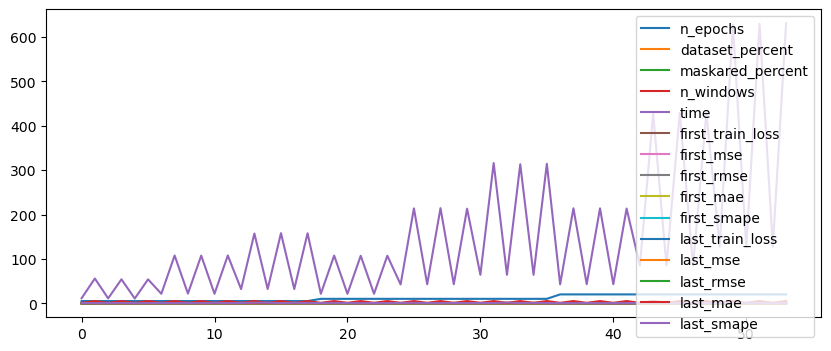

In [38]:
results_small.plot(figsize = (10,4))

<Axes: >

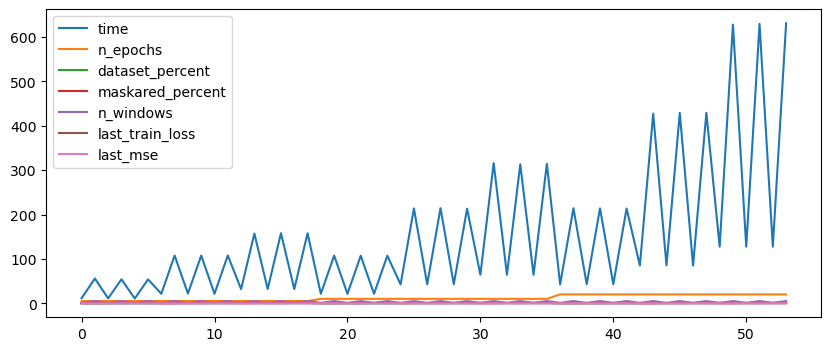

In [39]:
df_time_analysis_small = results_small[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "last_train_loss", 'last_mse']]
df_time_analysis_small.plot(figsize = (10,4))

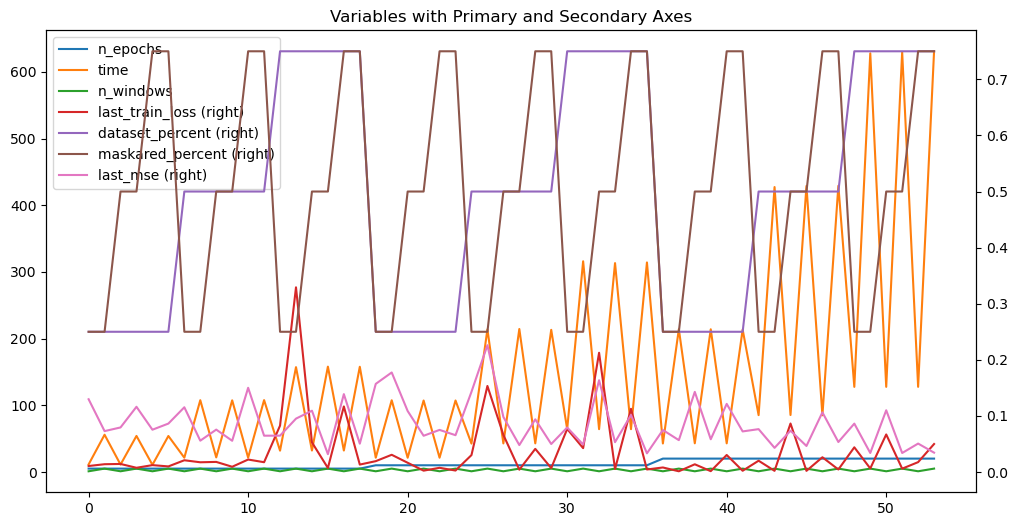

In [40]:
plot_with_multiple_secondary_y(df_time_analysis_small, ["n_epochs", "time", "n_windows"], ["last_train_loss", "dataset_percent", "maskared_percent", 'last_mse'])

In [ ]:
profile_small_df = df_time_analysis_small.copy(deep = True)

In [ ]:
#profile_small.to_notebook_iframe()

In [ ]:
profile_small_df.head()

In [ ]:
print(profile_small_df.dtypes)

In [ ]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')

# Convertir maskared_percent a float, manejando posibles errores
profile_small_df['maskared_percent'] = pd.to_numeric(profile_small_df['maskared_percent'], errors='coerce').astype(float)

In [ ]:
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_time_analysis_small'", explorative=True)

In [ ]:
 plot_correlation(profile_small_df)

A nivel de tiempo, se observa que:

- Apenas afecta el enmascarado, con una correlación negativa con el last loss. Lo mismo ocurre con el n_epochs
- Más tiempo parece hacer crecer el last_loss
- Lo que más influye es el porcentaje de dataset utilizado para el fine_tuning. Más dataset parece hacer empeorar por alguna razón
- El last loss está bastante relacionado con el tiempo dedicado al fine-tuning, como es de esperar. Pero. La correlación es positiva => más last loss => más tiempo.
- El número de ventanas parece ir en contra de bajar el loss.. quizá porque va de la mano del número de ventanas.


### Loss & metrics analysis

A nivel de losses, se observa (sin tener en cuenta mse, rmse, mae, smape): 
- Muy poca relación con el enmascarado, cosa que de primeras sorprende
- Mucha relación con el % de dataset utilizado en el fine-tuning
Por lo tanto,
    - vamos a filtrar el dataset para tener tiempos menores a 8 segundos
y buenos losses.
    - Veamos a partir de qué momento se obtienen unos losses razonables  en %.

In [ ]:
results_small.columns

In [ ]:
df_loss_small = results_small[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "first_train_loss", "last_train_loss", "first_mse", "last_mse"]].copy()

In [ ]:
df_loss_small["loss_train_percent"] = (df_loss_small['first_train_loss']-df_loss_small['last_train_loss'])*100/(df_loss_small['first_train_loss'])
df_loss_small["loss_train_percent"].plot()
df_loss_small["mse_percent"] = (df_loss_small['first_mse']-df_loss_small['last_mse'])*100/(df_loss_small['first_mse'])
df_loss_small["mse_percent"].plot()

In [ ]:
df_loss_small[df_loss_small["time"] < 8]["loss_train_percent"].plot()
df_loss_small[df_loss_small["time"] < 8]["mse_percent"].plot()

In [ ]:
# Filtrar filas donde "time" es menor a 8 segundos
df_loss_small_best_cases = df_loss_small[df_loss_small["time"] < 8].copy()

print("--------------------- Train -----------------")
# Filtrar los 5 mejores loss_percents
display(df_loss_small_best_cases.sort_values('loss_train_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_small_best_cases[df_loss_small_best_cases['dataset_percent'] < 0.50].sort_values('loss_train_percent', ascending = False)[:5])
print("---------------------- Eval ------------------")
# Filtrar los 5 mejores loss_percents
display(df_loss_small_best_cases.sort_values('mse_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_small_best_cases[df_loss_small_best_cases['dataset_percent'] < 0.50].sort_values('loss_train_percent', ascending = False)[:5])

In [ ]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df = df_loss_small[['time', 'n_epochs', 'dataset_percent', 'maskared_percent', 'n_windows', 'loss_train_percent', 'mse_percent']].copy()
profile_small_df.dtypes

In [ ]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')
# Convertir maskared_percent a float, manejando posibles errores
profile_small_df['maskared_percent'] = pd.to_numeric(profile_small_df['maskared_percent'], errors='coerce').astype(float)

In [ ]:
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_loss_small'", explorative=True)
plot_correlation(profile_small_df)

#### What if I focus on 0.25 dataset percent?

In [ ]:
profile_small_df_2 = df_time_analysis_small[df_time_analysis_small['dataset_percent'] == 0.25].drop(columns=['dataset_percent', 'time']).copy()

In [ ]:
profile_small_df_2.dtypes

In [ ]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df_2['n_epochs'] = pd.to_numeric(profile_small_df_2['n_epochs'], errors='coerce').astype('Int64')
profile_small_df_2['n_windows'] = pd.to_numeric(profile_small_df_2['n_windows'], errors='coerce').astype('Int64')
# Convertir maskared_percent a float, manejando posibles errores
profile_small_df_2['maskared_percent'] = pd.to_numeric(profile_small_df_2['maskared_percent'], errors='coerce').astype(float)

In [ ]:
profile_small_2 = ydp.ProfileReport(profile_small_df_2, title="Pandas Profiling Report for 'df_time_analysis_small' for < 0.25 dataset percent", explorative=True)
plot_correlation(profile_small_df_2)

* Correlación inversa entre maskared percent y last loss * => Aumentar maskared percent baja last_loss
* => Es parte de lo que queremos!

In [ ]:
#! ls errors*

In [ ]:
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_small.to('cpu')
for param in moment_small.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

## Moment-base

### Download the model

In [ ]:
print("Getting base artifact: ", enc_artifact_base_name)
enc_artifact_base  = wandb_api.artifact(enc_artifact_base_name, type='learner')
moment_base  = enc_artifact_base.to_obj()

### Select parameters

In [ ]:
total_cases_small      = len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")
n_epochs_list_base= [5, 10, 20]
dataset_percents_base  = [0.25, 0.5]
maskared_percents_base = [ 0.25, 0.5, 0.75]
sizes_base             = [1, 5, 10]
total_cases_base = len(n_epochs_list_base)*len(dataset_percents_base)*len(maskared_percents_base)*len(sizes)
print(f"Total cases: {total_cases_base}")
expected_time = total_time*total_cases_base/total_cases_small
print(f"Expected time: {expected_time} seconds | {expected_time/60} minutes | {expected_time/60/60} hours")

### Configure files and wether already computed or not

In [ ]:
already_computed_base = True
results_base = None
errors_base = None
file_errors_base = 'errors_base_24012025_1.csv'
file_results_base = 'results_base_24012025_1.csv'

### Execute cases

In [ ]:
results_base = None
errors_base = None
if already_computed_base:
    results_base = pd.read_csv(file_results_base, index_col=None, header=0)
    errors_base = pd.read_csv(file_errors_base, index_col=None, header=0)
else:
    results_base, errors_base = cases_loop(
        model             = moment_base, 
        n_epochs_list     = n_epochs_list_base, 
        dataset_percents  = dataset_percents_base, 
        maskared_percents = maskared_percents_base,
        n_sizes_list      = sizes_base, 
        summarized        = True,
        verbose           = 8
    )
    results_base.to_csv(file_results_base, index=False, header=True)
    errors_base.to_csv(file_errors_base, index=False, header=True)
    already_computed_base = True

In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_base)}")
display(errors_base.head())
print(f"Total results: {len(results_base)}")
display(results_base.head())

### Checking the errors

In [ ]:
len(results_base)

In [ ]:
error_base_window_sizes = list(errors_base['windows'].drop_duplicates())
error_base_window_sizes

In [ ]:
error_base_mssg = errors_base['error'].astype(str).drop_duplicates()
error_base_mssg

In [ ]:
base_windows = results_base['windows'].drop_duplicates()
filtered_windows_base = base_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
filtered_windows_base

#### Time analysis

In [ ]:
df_time_analysis_base = results_base[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "last_train_loss", "last_mse"]]

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_base, ["n_epochs", "time", "n_windows"], ["last_train_loss", "dataset_percent", "maskared_percent", "last_mse"])

In [ ]:
profile_base_df = df_time_analysis_base.copy(deep = True)
profile_base = ydp.ProfileReport(profile_base_df, title="Pandas Profiling Report for 'df_time_analysis_base'", explorative=True)

In [ ]:
plot_correlation(profile_base_df)

#### Loss & metrics analysis

In [ ]:
df_loss_base = results_base[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "first_train_loss", "last_train_loss", "first_mse", "last_mse"]].copy()
df_loss_base["loss_percent"] = (df_loss_base['first_train_loss']-df_loss_base['first_train_loss'])*100/(df_loss_base['first_train_loss'])
df_loss_base["loss_percent"].plot()
df_loss_base["mse_percent"] = (df_loss_base['first_mse']-df_loss_base['last_mse'])*100/(df_loss_base['first_mse'])
df_loss_base["mse_percent"].plot()

In [ ]:
df_loss_base[df_loss_base["time"] < 8]["loss_percent"].plot()
df_loss_base[df_loss_base["time"] < 8]["mse_percent"].plot()

In [ ]:
df_loss_base[df_loss_base["time"] < 20]

In [ ]:
# Filtrar filas donde "time" es menor a 8 segundos
df_loss_base_best_cases = df_loss_base[df_loss_base["time"] < 8].copy()

print("---- Mejoras en el entrenamiento ----")
# Filtrar los 5 mejores loss_percents
display(df_loss_base_best_cases.sort_values('loss_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])
print("---- Mejoras en la validación  ----")
# Filtrar los 5 mejores loss_percents
display(df_loss_base_best_cases.sort_values('mse_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('mse_percent', ascending = False)[:5])

In [ ]:
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

## Moment-large

### Download de large model

In [ ]:
already_computed_large = True
file_errors_large = 'errors_large_24012025_1.csv'
file_results_large = 'results_large_24012025_1.csv'

In [ ]:
if not already_computed_large:
    print("Getting large artifact: ", enc_artifact_large_name)
    enc_artifact_large = wandb_api.artifact(enc_artifact_large_name, type='learner')
    print(enc_artifact_large.name)
    moment_large = enc_artifact_large.to_obj()
    print(count_parameters(moment_large))

In [ ]:
total_cases_small      = len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")
total_cases_base = len(n_epochs_list_base)*len(dataset_percents_base)*len(maskared_percents_base)*len(sizes)
print(f"Total cases: {total_cases_base}")
expected_time = total_time*total_cases_base/total_cases_small
print(f"Expected time: {expected_time} seconds | {expected_time/60} minutes | {expected_time/60/60} hours")

n_epochs_list_large     = [5, 10, 20]
dataset_percents_large  = [0.25, 0.5] # No tendría sentido porque sería como hacer lo mismo que con mvp
maskared_percents_large = [0.25, 0.5, 0.75]
sizes_large             = [1, 5, 10]
print(f"Total cases: {len(n_epochs_list)*len(dataset_percents)*len(maskared_percents)*len(sizes)}")

In [ ]:
torch.cuda.memory_allocated()
torch.cuda.set_device(1)
torch.cuda.current_device()

In [ ]:
results_large = None
errors_large = None
if already_computed_large:
    results_large = pd.read_csv(file_results_large, index_col=None, header=0)
    errors_large = pd.read_csv(file_errors_large, index_col=None, header=0)
else:
    results_large, errors_large = cases_loop(
        model             = moment_large, 
        n_epochs_list     = n_epochs_list_large,
        dataset_percents  = dataset_percents_large, 
        maskared_percents = maskared_percents_large, 
        n_sizes_list      = sizes_large, 
        summarized        = True,
        save              = True,
        file_errors       =  file_errors_large,
        file_results      = file_results_large
    )
    already_computed_large = True

In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_large)}")
display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())
print("------------------")

In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_large)}")
display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_large.to('cpu')
for param in moment_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
gc.collect()
print("Mejorado: ", after-before)

#### Errors analysis

In [ ]:
if len(errors_large) > 0:
    error_large_window_sizes = list(errors_large['window'].drop_duplicates())
    error_large_window_sizes

In [ ]:
try:
    error_large_mssg = errors_large['error'].astype(str).drop_duplcates()
    display(error_large_mssg)
except Exception as e:
    print(e)

In [ ]:
large_windows = results_large['windows'].drop_duplicates()
print(large_windows.shape)
display(large_windows)

In [ ]:
filtered_windows_large = large_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
display(filtered_windows_large)

#### Time analysis

In [ ]:
df_time_analysis_large = results_large[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "last_train_loss", 'last_mse']]
df_time_analysis_large.plot(figsize = (10,4))

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_large, ["n_epochs", "time", "n_windows"], ["last_train_loss", 'last_mse', "dataset_percent", "maskared_percent"])

In [ ]:
profile_large_df = df_time_analysis_large.copy(deep = True)
profile_large = ydp.ProfileReport(profile_large_df, title = "Pandas Profiling Report for 'df_time_analysis_large'", explorative = True)
#profile_large.to_notebook_iframe()

In [ ]:
plot_correlation(profile_large_df)

In [ ]:
df_loss_large = results_large[["time", "n_epochs", "dataset_percent", "maskared_percent", "n_windows", "first_train_loss", "last_train_loss", "first_mse", "last_mse"]].copy()

In [ ]:
df_loss_large["loss_train_percent"] = (df_loss_large['first_train_loss']-df_loss_large['last_train_loss'])*100/(df_loss_large['first_train_loss'])
df_loss_large["mse_percent"] = (df_loss_large['first_mse']-df_loss_large['last_mse'])*100/(df_loss_large['first_mse'])
df_loss_large["loss_train_percent"].plot()
df_loss_large["mse_percent"].plot()

In [ ]:
df_loss_large_best_cases = df_loss_large[df_loss_large["time"] < 8].copy()
display(df_loss_large_best_cases)
print("--- train ---")
display(df_loss_large_best_cases[df_loss_large_best_cases["loss_train_percent"] > 0])
print("--- eval ---")
display(df_loss_large_best_cases[df_loss_large_best_cases["mse_percent"] > 0])
display(df_loss_large_best_cases)

In [ ]:
display(df_loss_large_best_cases.sort_values('loss_train_percent', ascending = False))

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
gc.collect()
torch.cuda.empty_cache()
after = torch.cuda.memory_allocated()
print(after)
print(after-before)

In [ ]:
gpu_tensors = []
for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            gpu_tensors.append(obj)
    except ReferenceError:
        continue # Omitir los objetos que ya han sido recolectados
print(len(gpu_tensors))

#### Loss & metrics analysis

In [ ]:
#| export
if verbose > 0: print("Execution ended")
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [ ]:
#| hide
if reset_kernel:
    os._exit(00)

# Memory checks

In [ ]:
snapshot = torch.cuda.memory_snapshot()
gpu_tensors = [obj['tensor'] for obj in snapshot if 'tensor' in obj]
for tensor_info in gpu_tensors:
    print(f"Size: {tensor_info['size']}, Device: {tensor_info['device']}, Data type: {tensor_info['dtype']}")
print(gpu_tensors)

In [ ]:
object_types = set()
for obj in snapshot:
    for key in obj.keys():
        object_types.add(key)
print("Tipos de objetos encontrados en el snapshot:")
for obj_type in sorted(object_types):
    print(obj_type)
heavier_obj = None
for obj in snapshot:
    if heavier_obj is None or obj['total_size'] > heavier_obj['total_size']: heavier_obj = obj
print(heavier_obj)

In [ ]:
before = torch.cuda.memory_allocated()
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_small.to('cpu')
for param in moment_small.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_base.to('cpu')
for param in moment_base.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_large.to('cpu')
for param in moment_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
error_small_window_sizes = list(errors_small_hoy['windows'].drop_duplicates())
error_small_window_sizes

In [ ]:
errors_small_hoy

In [ ]:
total_time = results_small_hoy['time'].sum()
print(f"{total_time} seconds")
print(f"{total_time/60} minutes")
print(f"{total_time/60/60} hours")

In [ ]:
df_time_analysis_small = results_small_hoy[["time", "n_epochs", "dataset_percent", "maskared_percent", "last_train_loss", 'last_mse']]
df_time_analysis_small.plot(figsize = (10,4))

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_small, ["n_epochs", "time"], ["last_train_loss", "dataset_percent", "maskared_percent", 'last_mse'])

In [ ]:
profile_small_df = df_time_analysis_small.copy(deep = True)

In [ ]:
print("--- Cases ---")
print("--- Number of epochs ---")
print(profile_small_df["n_epochs"].unique())
print("--- Dataset percent ---")
print(profile_small_df["dataset_percent"].unique())
print("--- Dataset maskared percent ---")
print(profile_small_df["maskared_percent"].unique())

In [ ]:
profile_small_df.head()

In [ ]:
print(profile_small_df.dtypes)

In [ ]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
#profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')

# Convertir maskared_percent a float, manejando posibles errores
profile_small_df['maskared_percent'] = pd.to_numeric(profile_small_df['maskared_percent'], errors='coerce').astype(float)

In [ ]:
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_time_analysis_small'", explorative=True)

In [ ]:
 plot_correlation(profile_small_df)